<a href="https://colab.research.google.com/github/VictorUceda/TrackNet-Padel/blob/main/Analisis_hits_padel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
input_name =  'punto_qatar'# 'Final_PremierQatar_Tie'#

#Inicialización de datos

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


import os 
# path = '/content/gdrive/MyDrive/Colab Notebooks/TrackNetv2/3_in_3_out'
path = '/content/gdrive/MyDrive/PadelData/'
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/')
!pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks


In [ ]:
import pickle
with open(path+input_name+'.playersbox', "rb") as fp:  
  person_results = pickle.load(fp)

import pickle
with open(path+input_name+'.ballpos', "rb") as fp:  
  ball_pos = pickle.load(fp)
#print(ball_pos)
if input_name[-11:] == 'punto_qatar':
  del ball_pos[272] #outlier
  del ball_pos[71] #outlier
  del ball_pos[72] #outlier
  del ball_pos[73] #outlier

def calc_ball_speed(ball_pos):
  last_f, last_pos = 0,[]
  for f, pos in ball_pos.items():
    if f-last_f < 10 and last_pos != []:
      vel = [pos[0][0] - last_pos[0][0], pos[0][1] - last_pos[0][1]]
      vel = [v/ (f-last_f) for v in vel]
      pos[0].append(vel)
    last_f, last_pos = f, pos
calc_ball_speed(ball_pos)
list(ball_pos.keys())[-5:]

[284, 285, 286, 287, 288]

#Analisis

In [ ]:
import numpy as np
import cv2


pista_aristas = np.array([[390,213], [890,213],[1114,622],[162,618]])
linea_saque_fondo = 250
linea_saque_cerca = 518
red_bajo = 350
red_alto = 300

def plot_court(img):
  pista_campo_fondo = np.array([[390,213], [890,213], [965,350], [315,350]])
  pista_campo_cerca = np.array([[315,350], [965,350],[1114,622],[162,618]])
  r_x, r_y = img.shape[1]/1280, img.shape[0]/720
  pista_campo_fondo = np.array([np.array([int(p[0]*r_x),int(p[1]*r_y)]) for p in pista_campo_fondo])
  pista_campo_cerca = np.array([np.array([int(p[0]*r_x),int(p[1]*r_y)]) for p in pista_campo_cerca])
  vis_img = cv2.polylines(img, np.int32([pista_campo_fondo]), True, (255,150,255),3)
  vis_img = cv2.polylines(img, np.int32([pista_campo_cerca]), True, (255,70,255),3)
  return vis_img

image = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/mmpose/last_img.png')
cv2.imwrite('/content/gdrive/MyDrive/Colab Notebooks/mmpose/last_img_court.png', plot_court(image))

True

In [ ]:
import numpy as np
import matplotlib.path as mpltPath
import math
import random
def rectangle_dist(bbox1, bbox2):
  if len(bbox1)>=4 and len(bbox2)>=4:
    c1 = [(bbox1[0]+bbox1[2])/2, (bbox1[1]+bbox1[3])/2]
    c2 = [(bbox2[0]+bbox2[2])/2, (bbox2[1]+bbox2[3])/2]
    d =  math.sqrt( (bbox2[0] - bbox1[0])**2 + (bbox2[1] - bbox1[1])**2 )
    d += math.sqrt( (bbox2[0] - bbox1[0])**2 + (bbox2[3] - bbox1[3])**2 )
    d += math.sqrt( (bbox2[2] - bbox1[2])**2 + (bbox2[1] - bbox1[1])**2 )
    d += math.sqrt( (bbox2[2] - bbox1[2])**2 + (bbox2[3] - bbox1[3])**2 )
    if d == 0:
      return d+random.random()/100
    return d/4
  elif len(bbox1)>=2 and len(bbox2)>=2:
    c1, c2 = bbox1, bbox2
    return math.sqrt( (c2[0] - c1[0])**2 + (c2[1] - c1[1])**2 )
  else:
    return None

pista = mpltPath.Path(pista_aristas)
#pista_c0 = mpltPath.Path(pista_campo_cerca)

def persons_in_court(persons, pista):
  players=[]
  for i in range(len(persons)):
    p = persons[i]
    if pista.contains_points([[p['bbox'][2],p['bbox'][3]]]) or \
        pista.contains_points([[p['bbox'][0],p['bbox'][3]]]):
      players.append(i)
      if len(players) == 4:
        break
  return [persons[i]['bbox'] for i in range(len(persons)) if i in players], \
          [persons[i]['bbox'] for i in range(len(persons)) if i not in players]

#players_box = []
#for f in person_results:
#  players_box.append(persons_in_court(f, pista))
#print(players_box)
  #print(p['bbox'])

#cv2.putText(img, str(i), (p['bbox'][0],p['bbox'][3]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (10, 255, 0), 1, cv2.LINE_AA)
#players_box
#cv2.imwrite('/content/gdrive/MyDrive/Colab Notebooks/mmpose/last_img_court.png', img)
#path.contains_points([(100,100)])

### Track jugador cercano

In [ ]:

import copy
def identify_players(persons, last_players, pista, debug = False):
  distances = []
  if len(persons) == 0:
    return []
  
  p_in_court, p_not_in_court = persons_in_court(persons, pista)
  if debug: print("--->debug call identify_players")
  if debug: print(len(last_players))
  if len(last_players) == 0:
    return [np.append(p_in_court[i], int(i)) for i in range(len(p_in_court))]
  
  players = []
  
  if len(p_in_court) > 0: #Asignar los jugadores dentro de la pista con su posición previa más cercana
    candidates = p_in_court
    distances_m = np.array([[rectangle_dist(p, person) for person in candidates] for p in last_players])
    while distances_m.size >0 and len(players) < 4 and distances_m.min() < 30:
      if debug: print(distances_m)
      distances_min = distances_m.min()
      if debug: print(distances_min)
      ij_min = np.where(distances_m == distances_min)
      
      (i_min,j_min) = tuple([i.item() for i in ij_min])

      pl = candidates[j_min] 
      pl = np.append(pl, last_players[i_min][5])
      pl = np.append(pl, distances_min)
      players.append(pl)
      if debug: print("player "+str(pl[5])+" localizado dentro de pista")
      if debug:print(last_players[i_min])
      if debug:print(candidates[j_min])
      #if debug:print((i_min,j_min))
      #distances_m = np.delete(distances_m, i_min, 0)
      #distances_m = np.delete(distances_m, j_min, 1)
      del last_players[i_min]
      del candidates[j_min]
      distances_m = np.array([[rectangle_dist(p, person) for person in candidates] for p in last_players])
    if len(last_players) == 0:
      while len(p_in_court) > 0 and len(players) < 4: #nuevos jugadores
        new_id = [i for i in range(4) if i not in [p[5] for p in players]][0]
        pl = np.append(p_in_court[0], new_id)
        pl = np.append(pl, -1)
        players.append(pl)
        if debug: print("nuevo player "+str(pl[5])+" detectado")
        del p_in_court[0]
  
  candidates = p_not_in_court
  if len(candidates) > 0 and len(last_players) > 0 and len(players) < 4: #buscar jugadores fuera de pista
    distances_m = np.array([[rectangle_dist(p, person) for person in candidates] for p in last_players])
    while distances_m.size >0 and len(players) < 4 and distances_m.min() < 30:
      distances_min = distances_m.min()
      ij_min = np.where(distances_m == distances_min)
      
      #print(distances_min)
      i_min, j_min = tuple([i.item() for i in ij_min])

      pl = candidates[j_min] 
      pl = np.append(pl, last_players[i_min][5])
      pl = np.append(pl, distances_min)
      players.append(pl)
      if debug: print("player "+str(pl[5])+" localizado dentro de pista")
      if debug:print(last_players[i_min])
      if debug:print(candidates[j_min])
      #if debug:print((i_min,j_min))
      #distances_m = np.delete(distances_m, i_min, 0)
      #distances_m = np.delete(distances_m, j_min, 1)
      del last_players[i_min]
      del candidates[j_min]
      distances_m = np.array([[rectangle_dist(p, person) for person in candidates] for p in last_players])
    
  return players


players_box = [[]]
for i in range(len(person_results)):
  players_box.append(identify_players(copy.deepcopy(person_results[i]), copy.deepcopy(players_box[-1]) if len(players_box)>0 else [], pista, False))
#  print("players frame "+str(i)+":")
#  print(players_box[i])
#print(players_box[1351])
#print(players_box[1352])
#print(max([max([p[-1] for p in per]) for per in players_box if per != []]))

### Procesado de pista y detector de plano central

In [ ]:
import math
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow # for image display

import matplotlib.pylab as plt




def avg(lst):
    return sum(lst)/len(lst)

def group_similar_lines(lines, v_h = 0):
  res_lines = []
  for l in lines:
    dist = [[abs((l[0+v_h]+l[2+v_h])/2 - avg([(s[0+v_h]+s[2+v_h])/2 for s in res_lines[i]])) , i] for i in range(len(res_lines))]
    if dist != []:
      dist.sort(key=lambda a: a[0])
      if dist[0][0] < 5:
        res_lines[dist[0][1]].append(l)
      else:
        res_lines.append([l])
    else:
      res_lines.append([l])
  res = []
  for g in res_lines:
    x = int(round(avg([(l[0+v_h]+l[2+v_h])/2 for l in g]), 0))
    width = max([max(l[0+v_h],l[2+v_h]) for l in g]) - min([min(l[0+v_h],l[2+v_h]) for l in g])   
    y_min = int(round(min([min([l[1-v_h],l[3-v_h]]) for l in g]), 0))
    y_max = int(round(max([max([l[1-v_h],l[3-v_h]]) for l in g]), 0))
    if v_h==0: #vertical line
      res.append([x, y_min, x, y_max, width])
    else: #horizontal line
      res.append([y_min, x, y_max, x, width])
  return res

def line_intersection_vh(line_v, line_h):
    if line_v[0] <= max(line_h[0], line_h[2]) and \
        line_v[0] >= min(line_h[0], line_h[2]) and \
        line_h[1] <= max(line_v[1], line_v[3]) and \
        line_h[1] >= min(line_v[1], line_v[3]):
      return [line_v[0], line_h[1]]
    return None

def is_central_camera(img, search_intersection=False, plot=False):
  r_x, r_y = img.shape[1]/1280, img.shape[0]/720
  t_points = [[int(637*r_x), int(251*r_y)], [int(637*r_x), int(518*r_y)], int(25*r_y)]
  thresh, img_bin = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY_INV)
  scale = 0.4
  img_bin = cv2.resize(img_bin, (int(img.shape[1]*scale), int(img.shape[0]*scale)), interpolation = cv2.INTER_AREA) # resize image
  dst = cv2.Canny(img_bin, 50, 200, None, 3)
   
  # Copy edges to the images that will display the results in BGR
  #cdst = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  cdst = np.copy(img)
  #cv2_imshow( cdstP)
    
  #lines = cv2.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)
    
  #if lines is not None:
  #  for i in range(0, len(lines)):
  #    rho = lines[i][0][0]
  #    theta = lines[i][0][1]
  #    a = math.cos(theta)
  #    b = math.sin(theta)
  #    x0 = a * rho
  #    y0 = b * rho
  #    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
  #    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
  #    cv.line(cdst, pt1, pt2, (0,255,0), 3, cv.LINE_AA)

  linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 10)
  instersection = []
  if linesP is not None:
    linesP = [[e/scale for e in line] for line in linesP]
    h_lines = [l[0] for l in linesP if abs(l[0][1]-l[0][3])<3]
    v_lines = [l[0] for l in linesP if abs(l[0][0]-l[0][2])<3]
    
    v_lines = group_similar_lines(v_lines)
    h_lines = group_similar_lines(h_lines, 1)
    
    if plot:
      for i in range(0, len(v_lines)):
        #print(linesP[i])
        l = v_lines[i]
        cdst = cv2.line(cdst, (l[0], l[1]), (l[2], l[3]), (0,255,100), 3, cv2.LINE_AA)
        #cv2.putText(img, str(i), (l[2], l[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,100), 2, cv2.LINE_AA)
      for i in range(0, len(h_lines)):
        #print(linesP[i])
        l = h_lines[i]
        cdst = cv2.line(cdst, (l[0], l[1]), (l[2], l[3]), (0,255,0), 3, cv2.LINE_AA)
        #cv2.putText(img, str(i), (l[2], l[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
        #print(v_lines)
    if search_intersection:
      for v in v_lines:
        for h in h_lines:
          instersection.append(line_intersection_vh(v, h))
      instersection = [i for i in instersection if i]
      if instersection != []:
        t_point_detected = 0
        for p in instersection:
          cv2.circle(img, (int(p[0]), int(p[1])), 8, (0,0,255), -1)
          if rectangle_dist(p, t_points[0]) < t_points[2] or \
              rectangle_dist(p, t_points[1]) < t_points[2]:
              t_point_detected +=1
        #print(t_point_detected)
        cv2_imshow(img)
        if t_point_detected >= 2:
          return img, True
    else: # search lines
      found_v, found_h = False, False
      for v in v_lines:
        if v[0] < t_points[0][0]+ t_points[2] and \
          v[0] > t_points[0][0] - t_points[2] and \
          abs(v[3]-v[1]) > 100:
          found_v = True
          break
      for h in h_lines:
        if ((h[1] < t_points[0][1]+ t_points[2] and \
          h[1] > t_points[0][1] - t_points[2]) or \
          (h[1] < t_points[1][1]+ t_points[2] and \
          h[1] > t_points[1][1] - t_points[2])) and \
          abs(h[2]-h[0]) > 100:
          found_h = True
          break
      if found_v and found_h:
        return img, True
  return cdst, False


## Analisis golpes

### Analisis punto_qatar

False
[4, 18, 22, 30, 35, 48, 53, 65, 70, 76, 96, 102, 104, 112, 147, 153, 164]
[(0, 6.666666666666667), (1, 11.045361017187261), (2, 11.045361017187261), (3, 11.40175425099138), (4, 8.246211251235321), (5, 4.0), (6, 6.0), (7, 6.324555320336759), (8, 4.123105625617661), (9, 2.23606797749979), (10, 4.527692569068709), (11, 8.761588446096143), (12, 11.423659658795863), (13, 18.384776310850235), (14, 21.540659228538015), (15, 23.323807579381203), (16, 25.059928172283335), (17, 25.553864678361276), (18, 25.888650451930133), (19, 28.844410203711913), (20, 31.622776601683793), (21, 26.90724809414742), (22, 34.058772731852805), (23, 35.38361202590826), (24, 28.284271247461902), (25, 31.240998703626616), (26, 34.058772731852805), (27, 26.40075756488817), (28, 24.413111231467404), (29, 20.808652046684813), (30, 21.95449840010015), (31, 20.591260281974), (32, 20.248456731316587), (33, 13.92838827718412), (34, 16.492422502470642), (35, 14.560219778561036), (36, 2.23606797749979), (37, 9.962429422

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


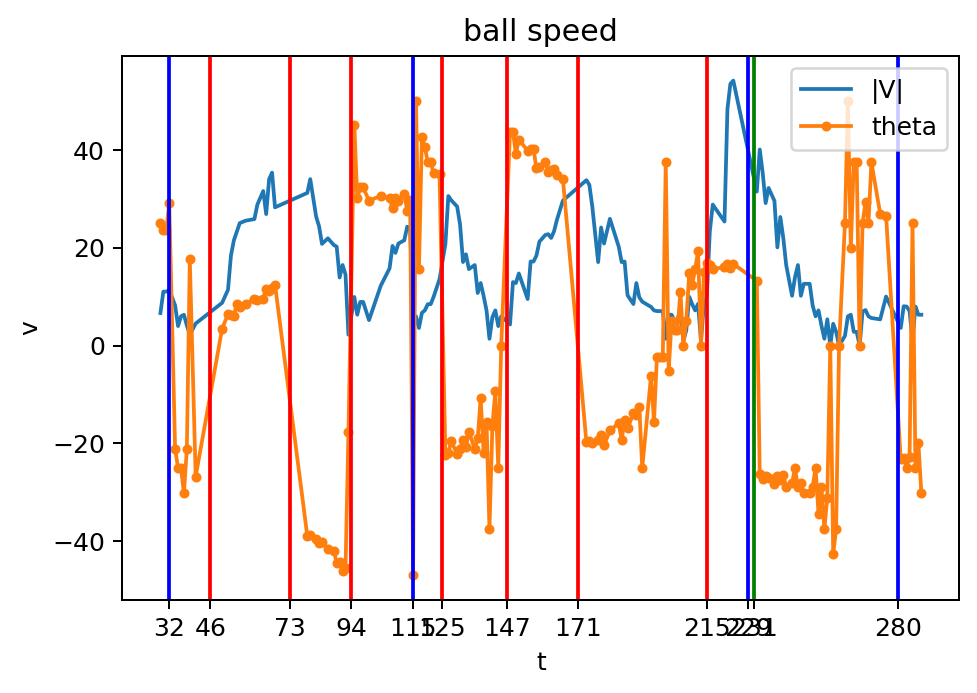

In [ ]:
import cmath
hits = [46, 73, 94, 125, 147, 171, 215]
wall = [231]
bounce = [32, 115, 229, 280]
ball_t = [int(t) for t in ball_pos.keys() if len(ball_pos[t][0])>2]
ball_v_x = [ball_pos[t][0][2][0] for t in ball_t if len(ball_pos[t][0])>2]
ball_v_y = [ball_pos[t][0][2][1] for t in ball_t if len(ball_pos[t][0])>2]
ball_v = [math.sqrt(x*x+y*y) for x,y in zip(ball_v_x, ball_v_y)]
ball_o = [cmath.polar(complex(x,y))[1]*100/(2*math.pi) for x,y in zip(ball_v_x, ball_v_y)]

to_delete = []

for i in range(1,len(ball_t)-1):
  if i==43: print(ball_v[i] < ball_v[i-1]-8 and ball_v[i] < ball_v[i+1]-8)
  if ball_v[i] < ball_v[i-1]-8 and ball_v[i] < ball_v[i+1]-8:
    to_delete.append(i)
print(to_delete)

ball_t = [ball_t[i] for i in range(len(ball_t)) if i not in to_delete]
ball_v_x = [ball_v_x[i] for i in range(len(ball_v_x)) if i not in to_delete]
ball_v_y = [ball_v_y[i] for i in range(len(ball_v_y)) if i not in to_delete]
ball_v = [ball_v[i] for i in range(len(ball_v)) if i not in to_delete]
ball_o = [ball_o[i] for i in range(len(ball_o)) if i not in to_delete]


print(list(zip(range(len(ball_v)), ball_v)))


import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 180

radians = True
if radians:
  plt.plot(ball_t, ball_v, label="|V|")
  plt.plot(ball_t, ball_o, label="theta", marker='.')
else:
  plt.plot(ball_t, ball_v_x, label="V_x", marker='.')
  plt.plot(ball_t, ball_v_y, label="V_y", marker='x')
plt.xticks(wall+bounce+hits)
for b in bounce:
  plt.axvline(x=b, color='b')
for h in hits:
  plt.axvline(x=h, color='r')
for w in wall:
  plt.axvline(x=w, color='g')

plt.plot()

plt.xlabel("t")
plt.ylabel("v")
plt.title("ball speed")
plt.legend()
plt.axes().xaxis.grid(True, which='minor')
plt.show()

### Analisis Qatar_trim

[12, 13, 14, 24, 25, 44, 57, 58, 59, 64, 67, 73, 74, 75, 76, 77, 80, 81, 82, 95, 100, 105, 109, 113, 118, 142, 146, 147]
[(0, 5.0990195135927845), (1, 4.47213595499958), (2, 8.94427190999916), (3, 10.0), (4, 4.949747468305833), (5, 14.142135623730951), (6, 15.264337522473747), (7, 10.816653826391969), (8, 19.235384061671343), (9, 12.206555615733702), (10, 19.72308292331602), (11, 12.806248474865697), (12, 14.317821063276353), (13, 10.198039027185569), (14, 12.649110640673518), (15, 8.246211251235321), (16, 2.8284271247461903), (17, 7.211102550927978), (18, 7.211102550927978), (19, 6.324555320336759), (20, 4.47213595499958), (21, 5.656854249492381), (22, 4.0), (23, 4.47213595499958), (24, 2.0), (25, 3.1622776601683795), (26, 0.0), (27, 3.0), (28, 4.123105625617661), (29, 3.1622776601683795), (30, 2.8284271247461903), (31, 10.770329614269007), (32, 0.0), (33, 6.324555320336759), (34, 8.246211251235321), (35, 6.324555320336759), (36, 5.830951894845301), (37, 4.47213595499958), (38, 1.4142

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


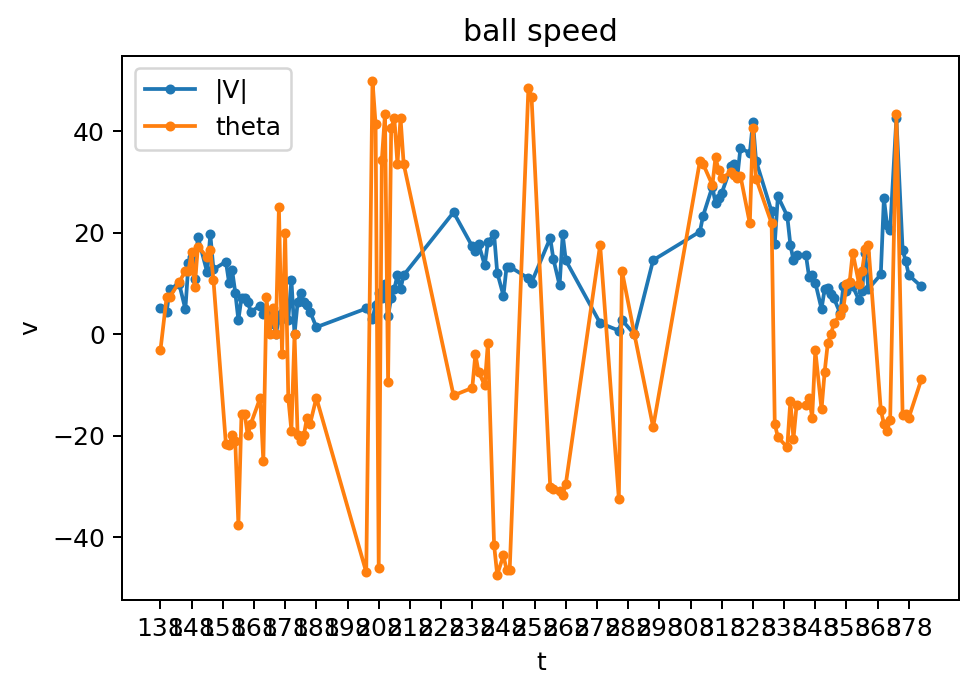

In [ ]:
import cmath
hits = []
wall = []
bounce = []

ball_t = [int(t) for t in ball_pos.keys() if len(ball_pos[t][0])>2 and t in range(138,525)]
ball_v_x = [ball_pos[t][0][2][0] for t in ball_t if len(ball_pos[t][0])>2]
ball_v_y = [ball_pos[t][0][2][1] for t in ball_t if len(ball_pos[t][0])>2]
ball_v = [math.sqrt(x*x+y*y) for x,y in zip(ball_v_x, ball_v_y)]
ball_o = [cmath.polar(complex(x,y))[1]*100/(2*math.pi) for x,y in zip(ball_v_x, ball_v_y)]

to_delete = []

for i in range(1,len(ball_t)-1):
  if (ball_v[i] < ball_v[i-1]-8 and ball_v[i] < ball_v[i+1]-8) or ball_v[i]>50:
    to_delete.append(i)
print(to_delete)

ball_t = [ball_t[i] for i in range(len(ball_t)) if i not in to_delete]
ball_v_x = [ball_v_x[i] for i in range(len(ball_v_x)) if i not in to_delete]
ball_v_y = [ball_v_y[i] for i in range(len(ball_v_y)) if i not in to_delete]
ball_v = [ball_v[i] for i in range(len(ball_v)) if i not in to_delete]
ball_o = [ball_o[i] for i in range(len(ball_o)) if i not in to_delete]


print(list(zip(range(len(ball_v)), ball_v)))


import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 180

radians = True
if radians:
  plt.plot(ball_t, ball_v, label="|V|", marker='.')
  plt.plot(ball_t, ball_o, label="theta", marker='.')
else:
  plt.plot(ball_t, ball_v_x, label="V_x", marker='.')
  plt.plot(ball_t, ball_v_y, label="V_y", marker='x')
plt.xticks(np.arange(min(ball_t), max(ball_t)-1, 10))
for b in bounce:
  plt.axvline(x=b, color='b')
for h in hits:
  plt.axvline(x=h, color='r')
for w in wall:
  plt.axvline(x=w, color='g')

plt.plot()

plt.xlabel("t")
plt.ylabel("v")
plt.title("ball speed")
plt.legend()
plt.axes().xaxis.grid(True, which='minor')
plt.show()

# Imprimir resultado a video

In [ ]:
import cv2
def plot_players(img, players):
  i = 1
  for p in players:
    img = cv2.rectangle(img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), (255,0,0), 2)
    cv2.putText(img, str(int(p[5])), (int(p[2]),int(p[3])), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (10, 255, 0), 1, cv2.LINE_AA)
    cv2.putText(img, str(round(p[-1],2)), (int((p[2]+p[0]-6)/2),int(p[1]-4)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (10, 255, 0), 1, cv2.LINE_AA)
    i += 1
  return img

def plot_ball(img, ball):
  center = (int(ball[0]), int(ball[1]))
  img = cv2.circle(img, center, 5, (0,0,255), 2)
  if len(ball)>2:
    speed = (int(ball[0]+1.5*ball[2][0]), int(ball[1]+1.5*ball[2][1]))
    img = cv2.arrowedLine(img, center, speed, (0,0,200), 2)
  return img

#players_box = [[p['bbox'] for p in per] for per in person_results]

video_path = path+input_name+'.mp4'
out_video_root = path+'vis_'+input_name+'.mp4'
print(out_video_root)
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
videoWriter = cv2.VideoWriter(out_video_root, fourcc, fps, size)
i = 0
while (cap.isOpened()):
        flag, img = cap.read()
        if not flag:
            break
        #modify img
        vis_img = img
        if not i%10:
          vis_img, camera_flag = is_central_camera(vis_img)
        if camera_flag:
          cv2.putText(vis_img, str(i), (80,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (10, 255, 0), 1, cv2.LINE_AA)
          vis_img = plot_court(vis_img)
          if i < len(players_box):
            vis_img = plot_players(vis_img, players_box[i])
          if i in ball_pos:
            vis_img = plot_ball(vis_img, ball_pos[i][0])
        else:
          cv2.putText(vis_img, str(i), (80,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (153, 0, 0), 1, cv2.LINE_AA)

        #save img
        videoWriter.write(vis_img)
        i += 1
cap.release()
videoWriter.release()

/content/gdrive/MyDrive/PadelData/vis_Final_PremierQatar_Tie.mp4


In [ ]:
!ffmpeg -i {path+'vis_'+input_name+'.mp4'} -c:v libx264 -preset slow -crf 20 -c:a aac -b:a 160k -vf format=yuv420p -movflags +faststart {path+'vis_'+input_name+'.mp4'}

### Analisis golpes

In [ ]:
from DLT import *
# Known 3D coordinates
xyz = [[-875, 0, 9.755], [442, 0, 9.755], [1921, 0, 9.755], [2951, 0.5, 9.755], [-4132, 0.5, 23.618],[-876, 0, 23.618]]
    # Known pixel coordinates
uv = [[76, 706], [702, 706], [1440, 706], [1867, 706], [264, 523], [625, 523]]

nd = 3
P, err = DLTcalib(nd, xyz, uv)
print('Matrix')
print(P)
print('\nError')
print(err)


[ 6.15603884e-01 -4.13878048e+02 -2.00661317e+01 -4.95516949e-01
 -1.33390601e-03 -8.68639595e+00 -5.95810574e+01 -1.51304061e-01
 -1.00624568e-02 -6.55267186e+01  1.60533207e+02  1.00000000e+00]
[[ 6.15603884e-01 -4.13878048e+02 -2.00661317e+01 -4.95516949e-01]
 [-1.33390601e-03 -8.68639595e+00 -5.95810574e+01 -1.51304061e-01]
 [-1.00624568e-02 -6.55267186e+01  1.60533207e+02  1.00000000e+00]]
[[ 2.08864341e-01 -1.85950110e+02  9.40861494e+01 -7.00800455e+02]
 [-5.39689559e-03 -3.51445840e+01  5.78328574e+01 -2.50683573e+02]
 [-7.64432802e-06 -4.97798641e-02  1.21955157e-01 -7.45655624e-01]]
Matrix
[[-2.80108315e-01  2.49378002e+02 -1.26179092e+02  9.39844658e+02]
 [ 7.23778566e-03  4.71324602e+01 -7.75597415e+01  3.36192157e+02]
 [ 1.02518211e-05  6.67598587e-02 -1.63554264e-01  1.00000000e+00]]

Error
2.578845649359634e-10


In [ ]:
pip install keras-ocr

In [ ]:
input_name = 'Final_PremiereQatar_2_21'# 'punto_qatar'#
import cv2
vidcap = cv2.VideoCapture(path+input_name+'.mp4')
camera_flag = False
in_point = False
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    


    if hasFrames:
      #image = image[25:100, 90:370]
      cv2.imwrite(path+str(sec)+" frame.png", image)     # save frame as PNG file
    return hasFrames
getFrame(70)

True

In [ ]:
#Importing the library
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()



# Analisis Puntos

(1080, 1920, 3)


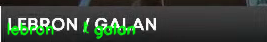

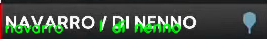

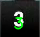

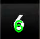

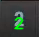

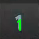

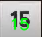

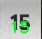

[['lebron', 'galan', 't'], ['navarro', 'di', 'nenno', 'l'], ['3'], ['6'], ['2'], ['1'], ['15'], ['15']]


In [ ]:
def parse_marcador(pipeline, frame, debug=False):
  import numpy as np
  import cv2
  from google.colab.patches import cv2_imshow # for image display

  box = [[98,25, 276,53, 0], [98,53, 276,79, 0], [276,28, 303,53, 0], [276,53, 303,79, 0], [303,28, 329,53, 0], [303,53, 329,79, 0], [329,28, 357,53, 1], [329,53, 357,79, 1] ]
  dim = [720, 1280]#[1080, 1920]
  if dim[0]!=frame.shape[0] or dim[1]!=frame.shape[1]:
    r_x, r_y = frame.shape[1]/dim[1], frame.shape[0]/dim[0]
    box = [[int(b[0]*r_x), int(b[1]*r_y), int(b[2]*r_x), int(b[3]*r_y), b[4]] for b in box]
  images = [frame[b[1]:b[3], b[0]:b[2]] for b in box]
  inv_images = [cv2.bitwise_not(img) for img in images]
  prediction_groups = pipeline.recognize(images)
  prediction_groups_inv = pipeline.recognize(inv_images)

  if debug:
    for pred, pred_i, img in zip(prediction_groups, prediction_groups_inv, images):
      for p in pred+pred_i:
        cv2.putText(img, str(p[0]), (int(p[1][3][0]),int(p[1][3][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (10, 255, 0), 1, cv2.LINE_AA)
      cv2_imshow(img)
  res1, res2 = [], []
  return [[p[0] for p in pred if len(p)>0] for pred in prediction_groups]
  if len(prediction_groups)>1:
    res1.append([p[0] for p in prediction_groups[0]])
    res2.append([p[0] for p in prediction_groups[1]])
  if len(prediction_groups)>3:
    res1.append(prediction_groups[2][0][0])
    res2.append(prediction_groups[3][0][0])
  if len(prediction_groups)>5:
    res1.append(prediction_groups[4][0][0])
    res2.append(prediction_groups[5][0][0])
  if len(prediction_groups[6])>7:
    res1.append(prediction_groups[6][0][0])
    res2.append(prediction_groups[7][0][0])
  return [res1, res2 ]

# Get a set of three example images
#image = keras_ocr.tools.read(path+'100 frame.png')

frame = keras_ocr.tools.read(path+'70 frame.png')
print(frame.shape)
print(parse_marcador(pipeline, frame , True))

In [ ]:
from imutils.video import FileVideoStream
from imutils.video import FPS
import numpy as np
import argparse
import imutils
import time
import cv2
import matplotlib.pyplot as plt
import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

video_path = path+input_name+'.mp4'
out_video_root = path+'vis_'+input_name+'.mp4'


cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
videoWriter = cv2.VideoWriter(out_video_root, fourcc, fps, size)
cap.release()



print("[INFO] starting video file thread...")
fvs = FileVideoStream(video_path).start()
time.sleep(1.0)
# start the FPS timer
fps = FPS().start()
i = 0
camera_flag, in_point = False, False
ini = 0
marcador = []
# loop over frames from the video file stream
while fvs.running():
  frame = fvs.read()
  if frame:
    cv2.putText(frame, str(i), (80,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (10, 255, 0), 1, cv2.LINE_AA)
    if not i%15:
      img, camera_flag = is_central_camera(frame, False)
    if camera_flag and not in_point:
      in_point = True
      marcador = parse_marcador(pipeline, frame, debug=False)
      ini = i
    if not camera_flag and in_point:
      in_point = False
      print(str(ini)+"; "+str(i)+";"+str(marcador))
    if i == ini+30 and in_point:
      marcador = parse_marcador(pipeline, frame, debug=False)
    if in_point:
      frame = plot_court(frame)
    i += 1
    videoWriter.write(frame)
  if fvs.Q.qsize() < 2:  # If we are low on frames, give time to producer
    time.sleep(0.001)  # Ensures producer runs now, so 2 is sufficient
  fps.update()

# stop the timer and display FPS information
fps.stop()
print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

fvs.stop()
videoWriter.release()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
[INFO] starting video file thread...
0; 225;[[], [], [], [], [], [], [], []]
600; 960;[['lebron', 'galan', 'i'], ['navarrol', 'di', 'nenno'], ['3'], ['6'], ['2'], [], ['15'], ['o']]
1275; 2340;[['lebron', 'galan', 'f'], ['navarro', 'di', 'nenno', 'f'], ['3'], ['6'], ['2'], [], ['15'], ['15']]
2580; 2595;[[], [], [], [], [], [], [], []]
2895; 3495;[['lebron', 'galan', 'l'], ['navarro', 'di', 'nenno', 'l'], ['3'], ['6'], ['2'], [], ['15'], ['30']]
4215; 4230;[[], [], [], [], [], [], [], []]
4380; 4500;[['lebron', 'galan', 'f'], ['navarro', 'di', 'nenno', 'i'], ['3'], ['6'], ['2'], [], ['30'], ['30']]
4710; 5385;[['lebron', 'galan', 'i'], ['navarro', 'di', 'nenno', 'f'], ['3'], ['6'], ['z'], ['1'], ['30'], ['30']]
6030; 6195;[['lebron', 'galan', 'e'], ['navarrol', 'di', 'nenno'], ['3'], ['6'], ['2'], [], ['30'], ['40']]
6780; 7050;[['lebron', 'galan', 'f'], ['navarro', 'di', 'nenno', 'f'], ['3'], ['

AttributeError: ignored

In [ ]:
points = [[0, [['lebron', 'l', 'galan'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], ['6'], ['6'], [], []], 390], 
[660, [['galan', 'lebron', 'i'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], ['6'], ['6'], [], []], 1215], 
[1530, [['galan', 'lebron', 'i'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], ['6'], ['6'], ['2'], []], 2190], 
[3360, [['lebron', 'galan', 'l'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], [], ['6'], ['2'], []], 3600], 
[4050, [['galan', 'lebron', 'i'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], ['6'], ['6'], ['3'], []], 4320], 
[5280, [['galan', 'lebron', 'i'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], [], ['6'], ['3'], ['2']], 5745], 
[7050, [['galan', 'lebron', 'i'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], ['6'], ['6'], ['3'], ['3']], 7335], 
[7530, [['galan', 'lebron', 'l'], ['navarro', 'nenno', 'il', 'di'], ['3'], ['6'], ['6'], ['6'], ['3'], ['3']], 7905], 
[8430, [['lebron', 'galan', 'l'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], ['6'], ['6'], ['3'], []], 8700], 
[9150, [['galan', 'lebron', 'i'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], [], ['6'], [], []], 9615], 
[10680, [['galan', 'lebron', 'i'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], ['6'], ['6'], [], ['5']], 11550], 
[12090, [['galan', 'lebron', 'i'], ['navarro', 'nenno', 'i', 'di'], ['3'], ['6'], ['6'], ['6'], [], ['6']], 12660]]